In [67]:
import glob

import numpy as np
from cfgrib.xarray_store import open_dataset
import xarray as xr
import h5py

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


import gcsfs
import load_data 
import importlib
importlib.reload(load_data)
from load_data import load_and_regrid_data, get_lon_lat_reg, get_ai_models, get_cGAN, get_IMERG_year
from regridding import regrid


# Boring regridding first

In [68]:
models = ['graphcast', 'fuxi']

df_all = []

for year in [2021,2022,2023]:
    if year>2022:
        df_all.append(load_and_regrid_data(models, year, era5=True, ARCO_ERA5=True, true_netcdf=False))
    else:
        df_all.append(load_and_regrid_data(models, year, era5=False, ARCO_ERA5=False, true_netcdf=True))



100%|███████████████████████████████████████████████████████████████████████| 366/366 [26:23<00:00,  4.33s/it]


(366, 384, 352)
Regridding data for models: ['graphcast', 'fuxi']  at year: 2023 (384,) (352,)


In [ ]:
df_ai = xr.concat([df[0] for df in df_all],dim='time')

df_IMERG = xr.concat([df[1] for df in df_all[:-1]],dim='time')
df_IMERG = xr.concat([df_IMERG, df_all[-1][2]],dim='time')
df_IMERG = xr.concat([get_IMERG_year(2018), get_IMERG_year(2019), get_IMERG_year(2020), 
                      df_IMERG], dim='time')

In [71]:
df_era5 = df_all[-1][1]

In [17]:
df_cgan = get_cGAN('/network/group/aopp/predict/TIP017_COOPER_SURFACE/cGAN/ICPAC/24h_IMERG_v7/',2020)

In [37]:
df_era5

<xarray.DataArray 'total_precipitation_24hr' (time: 7340, lat: 384, lon: 352)> Size: 4GB
dask.array<astype, shape=(7340, 384, 352), dtype=float32, chunksize=(1, 77, 70), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 59kB 2018-01-01 ... 2023-01-09T18:00:00
  * lat      (lat) float32 2kB -13.65 -13.55 -13.45 -13.35 ... 24.45 24.55 24.65
  * lon      (lon) float32 1kB 19.15 19.25 19.35 19.45 ... 54.05 54.15 54.25
Attributes:
    long_name:      Total precipitation
    short_name:     tp
    units:          m
    regrid_method:  conservative

In [56]:
df_ai

<xarray.DataArray 'tp' (model: 2, time: 853, lat: 384, lon: 352)> Size: 922MB
dask.array<concatenate, shape=(2, 853, 384, 352), dtype=float32, chunksize=(1, 366, 157, 143), chunktype=numpy.ndarray>
Coordinates:
  * model    (model) object 16B 'graphcast' 'fuxi'
  * time     (time) datetime64[ns] 7kB 2021-09-01 2021-09-02 ... 2024-01-01
  * lat      (lat) float32 2kB -13.65 -13.55 -13.45 -13.35 ... 24.45 24.55 24.65
  * lon      (lon) float32 1kB 19.15 19.25 19.35 19.45 ... 54.05 54.15 54.25
Attributes:
    regrid_method:  conservative

# Experimental fitting with EasyUQ

In [2]:
import sys
sys.path.insert(1, '/home/n/nath/aimodels_exp/')

import isodistrreg
import xarray as xr
import importlib
importlib.reload(isodistrreg)


<module 'isodistrreg' from '/home/n/nath/aimodels_exp/isodistrreg.py'>

In [ ]:
import pandas as pd

times_train = np.arange('2018-01-01','2020-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]')
times_test = np.arange('2020-01-01','2021-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]')


models =['fuxi','graphcast']
elev = xr.open_dataset('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD//cGAN/constants-regICPAC/elev.nc').to_dataarray()

idr_fit = {}
preds = {}
y_test = {}
crps = {}

for model in ['era5']:
    fit_results = isodistrreg.fit_idr_gp(df_era5_regridded.rename({'total_precipitation_24hr':'precipitation'}).precipitation,
                                              df_IMERG.precipitation, times_train, times_test, parallel=True,n_workers=80)

    idr_fit[model] = fit_results[0]
    preds[model] = fit_results[1]
    y_test[model] = fit_results[2]
    

    joblib.dump(idr_fit[model],'/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/era5/postprocessing_results/idr_fit_land.pkl')
    joblib.dump(preds[model],'/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/era5/postprocessing_results/preds_test_land.pkl')
    joblib.dump(y_test[model],'/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/era5/postprocessing_results/y_test_land.pkl')




Text(0, 0.5, 'Density')

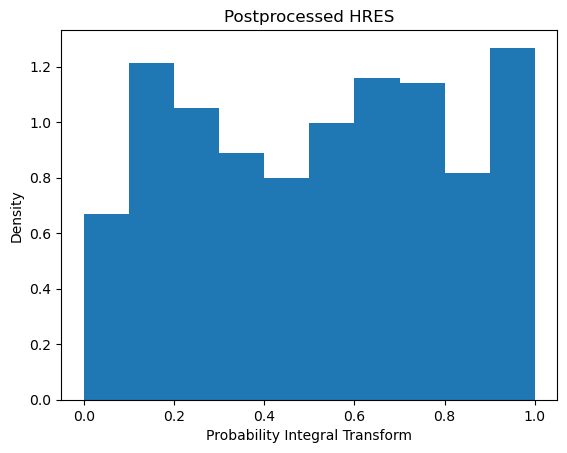

In [107]:
import rpy2.robjects as ro

i_elev = 1

## try reproduce the example
pit = isodistrreg.pit(preds_fit[i_elev], ro.FloatVector(y_test[i_elev]))

a, b, x = plt.hist(np.asarray(pit), density = True)
plt.title("Postprocessed HRES")
plt.xlabel("Probability Integral Transform")
plt.ylabel("Density")


# Make some plots

In [329]:
lons_reg = df_ai.lon.values
lats_reg = df_ai.lat.values

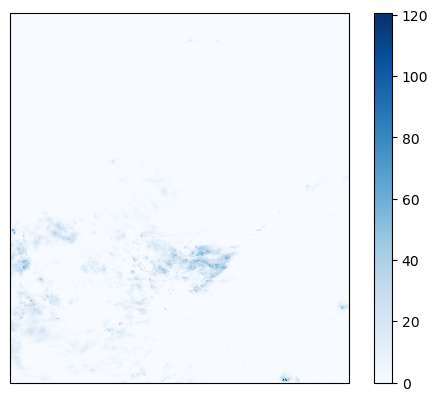

In [337]:
ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(lons_reg, lats_reg, df_IMERG.precipitation.isel(time=-20).values*24, cmap='Blues')
plt.colorbar(mesh)

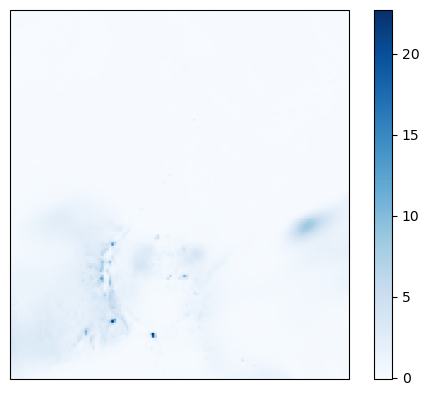

In [44]:
ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(df_ai.lon.values, df_ai.lat.values, df_ai.sel({'model':'graphcast'}).values[90,:,:]*1000/6, cmap='Blues')
plt.colorbar(mesh)





# Calculate MAE

(0.0, 1.0, 0.0, 1.0)

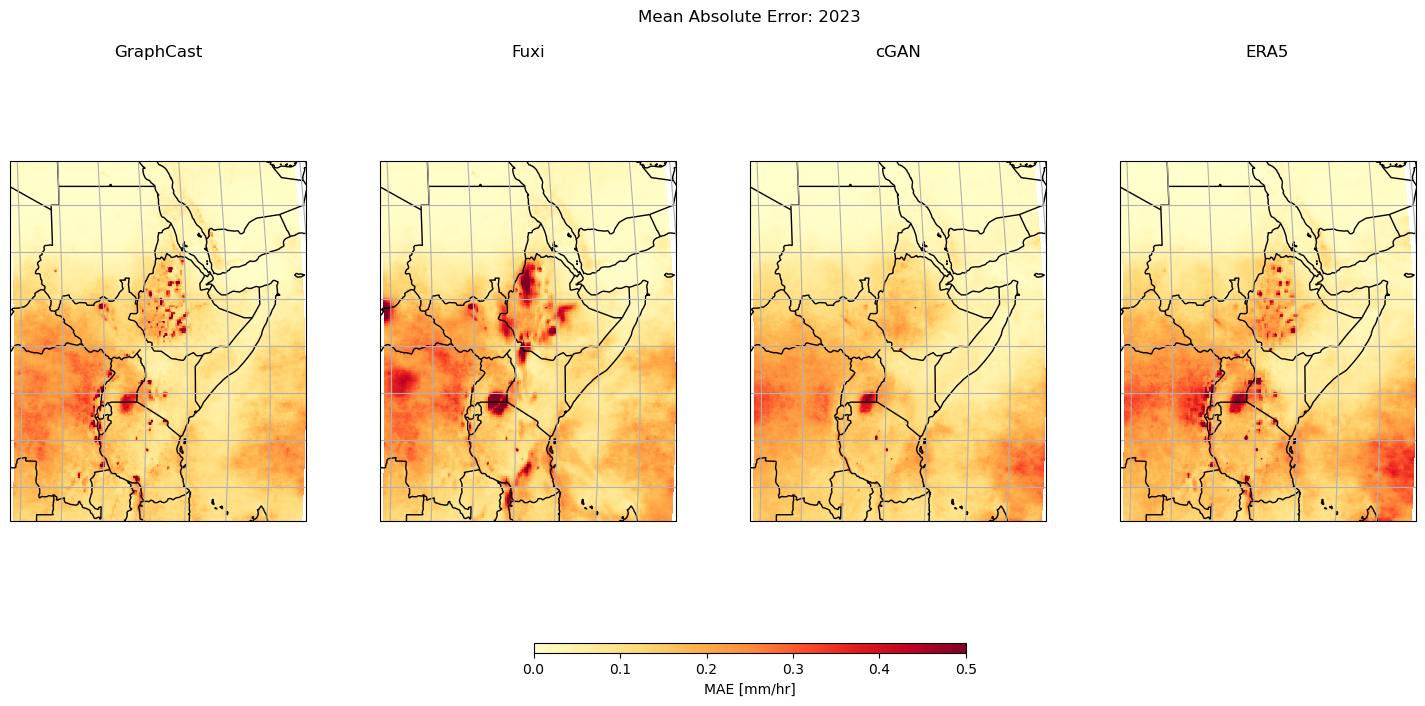

In [91]:
import verification_stats
importlib.reload(verification_stats)

from verification_stats import MAE_xarray, QQ_plot_elev
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

n_col = 4
n_row = 2

fs_title=16

fig=plt.figure(figsize=(21,9))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*10, n_col*5+2, wspace=0, hspace=0.2) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

times = np.arange('2023-01-01', '2023-12-31', np.timedelta64(1, 'D'), dtype=np.datetime64)
header_time = '2023'
#times=df_ai.time.values#np.arange('2023-03-01', '2023-06-01', np.timedelta64(1, 'D'), dtype=np.datetime64)
model_label_dict = {'graphcast': 'GraphCast', 'fuxi': 'Fuxi', 'era5':'ERA5','cGAN':'cGAN'}

i_y = 0

axtitle = plt.subplot(grid[0,2:-2])
plt.title('Mean Absolute Error: '+header_time)
plt.axis('off')

for model in ['graphcast','fuxi','cGAN','era5']:

    axsubtitle = plt.subplot(grid[1,i_y*5+1:i_y*5+5])
    plt.title(model_label_dict[model])
    plt.axis('off')
    
    ax = plt.subplot(grid[1:-3,i_y*5+1:i_y*5+5], projection=ccrs.Robinson(central_longitude=0))
    ax.gridlines()
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    
    #ax.set_xticks(np.unique(lons_reg.astype(int)))
    #ax.set_yticks(np.unique(lats_reg.astype(int)))

    ax.set_xlabel('Longitude (degrees East)')
    ax.set_ylabel('Latitude (degrees North)')

    if model == 'era5':
        mae = MAE_xarray(df_era5.resample({'time':'D'}).mean('time')*1000/6, df_IMERG.drop_duplicates('time').precipitation,
                         np.arange('2020-01-01', '2021-01-01', np.timedelta64(1, 'D'), dtype=np.datetime64),
                        log=False)
        
    elif model == 'cGAN':
        mae = MAE_xarray(df_cgan.mean('member')\
                         .drop_vars(['fcst_valid_time'])\
                         .rename({'latitude':'lat','longitude':'lon'})\
                         .precipitation.squeeze(dim='valid_time',drop=True), 
                         df_IMERG.drop_duplicates('time').precipitation, 
                         np.arange('2020-01-01', '2021-01-01', np.timedelta64(1, 'D'), dtype=np.datetime64),
                         log=False)
    else:    
        mae = MAE_xarray(df_ai.sel({'model':model}).drop_vars(['model'])\
                         .compute()*1000/24,
                         df_IMERG.drop_duplicates('time').precipitation, 
                         np.arange('2023-01-01', '2024-01-01', np.timedelta64(1, 'D'), dtype=np.datetime64), log=False, normalised=False)
        
    mesh = ax.pcolormesh(mae.lon.values, mae.lat.values, mae.values, cmap='YlOrRd', vmin = 0, vmax = 0.5, transform=ccrs.PlateCarree())

    i_y+=1

axcbar = plt.subplot(grid[-4:-2, 2:-2])
cbar = plt.colorbar(mesh, ax = axcbar, orientation='horizontal', aspect=45)
cbar.ax.set_xlabel('MAE [mm/hr]')

plt.axis('off')
                     
                     



# Calculate explained variance

(0.0, 1.0, 0.0, 1.0)

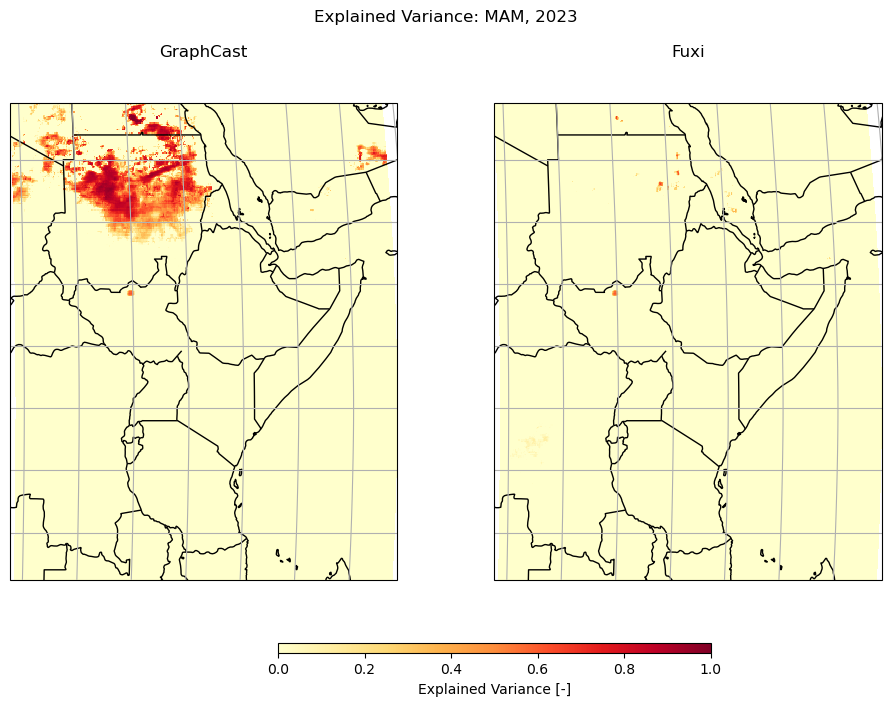

In [119]:
import verification_stats
importlib.reload(verification_stats)

from verification_stats import MAE_xarray, QQ_plot_elev, explained_variance_xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

n_col = 2
n_row = 2

fs_title=16

fig=plt.figure(figsize=(15,9))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*10, n_col*5+2, wspace=0, hspace=0.2) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#times = np.arange('2023-03-01', '2023-06-01', np.timedelta64(1, 'D'), dtype=np.datetime64)
header_time = 'MAM, 2023'
times=None#np.arange('2023-03-01', '2023-06-01', np.timedelta64(1, 'D'), dtype=np.datetime64)
model_label_dict = {'graphcast': 'GraphCast', 'fuxi': 'Fuxi', 'era5':'ERA5'}

i_y = 0

axtitle = plt.subplot(grid[0,4:7])
plt.title('Explained Variance: '+header_time)
plt.axis('off')

for model in ['graphcast', 'fuxi']:

    axsubtitle = plt.subplot(grid[1,i_y*5+1:i_y*5+5])
    plt.title(model_label_dict[model])
    plt.axis('off')
    
    ax = plt.subplot(grid[1:-3,i_y*5+1:i_y*5+5], projection=ccrs.Robinson(central_longitude=0))
    ax.gridlines()
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    
    #ax.set_xticks(np.unique(lons_reg.astype(int)))
    #ax.set_yticks(np.unique(lats_reg.astype(int)))

    ax.set_xlabel('Longitude (degrees East)')
    ax.set_ylabel('Latitude (degrees North)')

    if model == 'era5':
        mae = explained_variance_xarray(df_era5.resample({'time':'D'}).mean('time')*1000/6, df_IMERG.drop_duplicates('time').precipitation,
                         np.arange('2020-01-01', '2021-01-01', np.timedelta64(1, 'D'), dtype=np.datetime64),
                        log=False)
        
    elif model == 'cGAN':
        mae = explained_variance_xarray(df_cgan.mean('member')\
                         .drop_vars(['fcst_valid_time'])\
                         .rename({'latitude':'lat','longitude':'lon'})\
                         .precipitation.squeeze(dim='valid_time',drop=True), 
                         df_IMERG.drop_duplicates('time').precipitation, 
                         np.arange('2020-01-01', '2021-01-01', np.timedelta64(1, 'D'), dtype=np.datetime64),
                         log=False)
    else:    
        mae = explained_variance_xarray(df_ai.sel({'model':model}).drop_vars(['model'])\
                         .compute()*1000/24,
                         df_IMERG.drop_duplicates('time').precipitation, 
                         np.arange('2023-01-01', '2024-01-01', np.timedelta64(1, 'D'), dtype=np.datetime64), log=False, normalised=False)
        
    mesh = ax.pcolormesh(ev.lon.values, ev.lat.values, ev.values, cmap='YlOrRd', vmin=0, vmax=1, transform=ccrs.PlateCarree())

    i_y+=1

axcbar = plt.subplot(grid[-4:-2, 2:-2])
cbar = plt.colorbar(mesh, ax = axcbar, orientation='horizontal', aspect=45)
cbar.ax.set_xlabel('Explained Variance [-]')

plt.axis('off')
                     
          

/tmp/user/28197/ipykernel_1355170/3663653306.py:17: RuntimeWarning: invalid value encountered in log10
  ax.hist(np.log10(1e-5+df_ai.sel({'model':'graphcast'}).sum('step').values[:,elev>2500].flatten()*1000/6), bins=100, color='green', alpha=0.7, density=True, label='GraphCast')


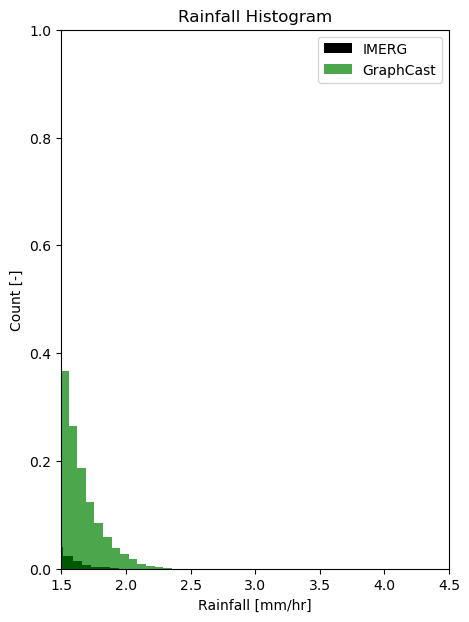

In [366]:
from regridding import regrid
fs_title=16

fig=plt.figure(figsize=(5,7))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

elev = xr.open_dataset('~/cGAN/constants-regICPAC/elev.nc')
elev=elev.elevation.values

ax = fig.add_subplot(1,1,1)
ax.hist(np.log10(1e-5+df_IMERG.precipitation.values[:,elev>2500].flatten()*24), bins=100, color='black', density=True, label='IMERG')
ax.hist(np.log10(1e-5+df_ai.sel({'model':'graphcast'}).sum('step').values[:,elev>2500].flatten()*1000/6), bins=100, color='green', alpha=0.7, density=True, label='GraphCast')
ax.hist(np.log10(1e-5+df_ai.sel({'model':'fuxi'}).mean('step').values[:,elev>2500].flatten()*1000), bins=100, color='orange', alpha=0.5, density=True, label='Fuxi')

ax.set_xlim(0,4.5)
ax.set_ylim(0,1)

ax.set_xlabel('Rainfall [mm/hr]')
ax.set_ylabel('Count [-]')

plt.title('Rainfall Histogram')

plt.legend()



# Plot Radial Averaged Power Spectral Density

In [78]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

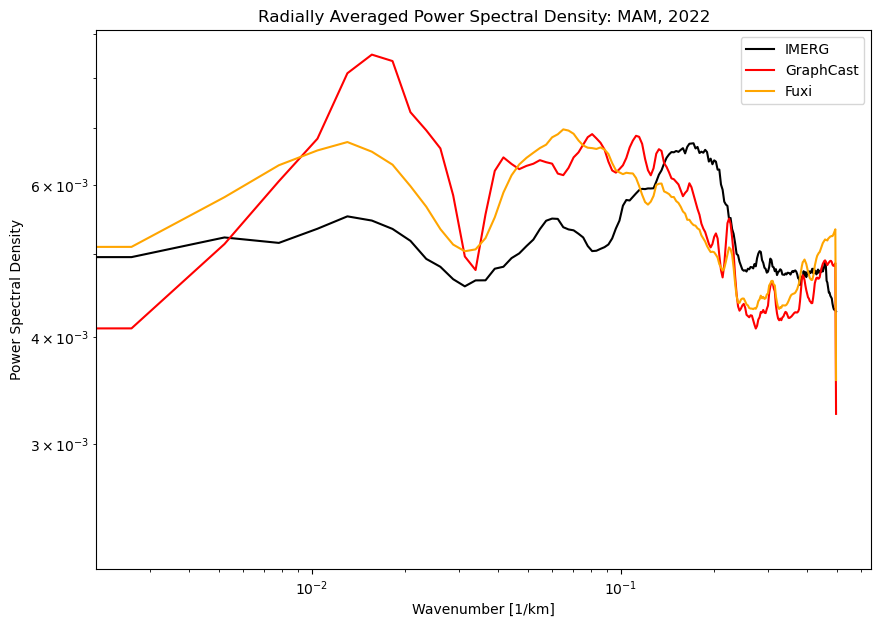

In [82]:
import verification_stats
import load_data
importlib.reload(verification_stats)
importlib.reload(load_data)

from verification_stats import rapsd
from load_data import postprocess

n_col = 1
n_row = 2

fs_title=16

fig=plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

model_label_dict = {'graphcast': 'GraphCast', 'fuxi': 'Fuxi', 'era5':'ERA5'}


grid = plt.GridSpec(n_row*10, n_col*5+2, wspace=0, hspace=0.2) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#times = np.arange('2023-03-01', '2023-06-01', np.timedelta64(1, 'D'), dtype=np.datetime64)
header_time = 'MAM, 2022'
#times=np.arange('2022-03-01T06:00:00.000000000', '2022-06-01T06:00:00.000000000', np.timedelta64(1, 'D'), dtype='datetime64[ns]')
times = None #np.arange('2022-03-01', '2022-06-01', np.timedelta64(1, 'D'), dtype='datetime64[ns]')
model_label_dict = {'graphcast': 'GraphCast', 'fuxi': 'Fuxi', 'era5':'ERA5'}

axtitle = plt.subplot(grid[0,2:-2])
plt.title('Radially Averaged Power Spectral Density: '+header_time)
plt.axis('off')

#df_postprocessed = postprocess(df_ai.sel({'time':times}), df_IMERG.sel({'time':times}))

psd_IMERG, freq_IMERG = rapsd(df_IMERG.precipitation.values,return_freq=True, normalize=True)

colours = ['red', 'orange']

ax = fig.add_subplot(1,1,1)
ax.plot(freq_IMERG, psd_IMERG, color='black', label='IMERG')

ax.set_xlabel('Wavenumber [1/km]')
ax.set_ylabel(r'Power Spectral Density')

i_y = 0

for model in ['graphcast','fuxi']:
    if model == 'era5':

        psd, freq = rapsd(df_era5.sel({'time':times}).values*1000/6,return_freq=True)
    else:    
        psd, freq = rapsd(df_ai.sel({'model':model}).values*1000/24,return_freq=True, normalize=True)
        #psd_post, freq_post = rapsd(df_postprocessed.sel({'model':model}).values*1000/6,return_freq=True,normalize=True)
    
    ax.plot(freq, smooth(psd,3), color=colours[i_y], label=model_label_dict[model])
    #ax.plot(freq_post, smooth(psd_post,3), color=colours[i_y], label=model_label_dict[model]+' post-processed', linestyle='dashed')
                     
    i_y+=1
    
ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
                     

In [286]:
import verification_stats
import load_data
importlib.reload(verification_stats)
importlib.reload(load_data)

from verification_stats import rapsd
from load_data import postprocess

df_postprocessed = postprocess(df_ai.sel({'time':times}), df_IMERG.sel({'time':times}))


0.34613295543399053


/home/n/nath/anaconda3/envs/kerchunk_2024/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/n/nath/anaconda3/envs/kerchunk_2024/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[[0.16897351 0.35724308]
 [0.19302337 0.40843618]
 [0.18160565 0.13418821]
 [0.18244721 0.06400989]]
0.34613295543399053
[[0.16926083 0.35724308]
 [0.19233146 0.40843618]
 [0.18139544 0.13418821]
 [0.17960289 0.06400989]]


<Figure size 600x700 with 0 Axes>

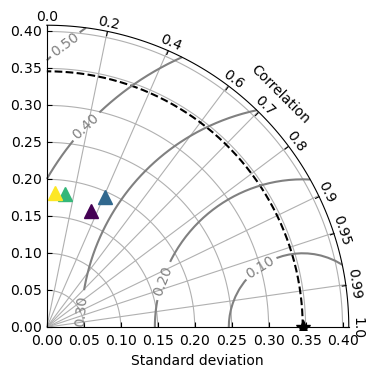

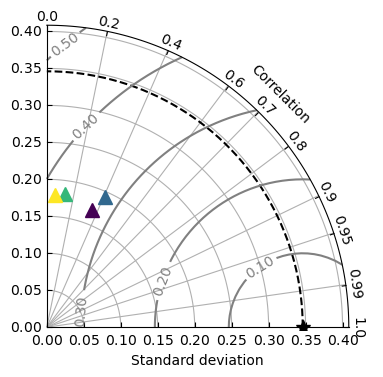

In [298]:
import verification_stats
import load_data
importlib.reload(verification_stats)

from verification_stats import plot_taylor

elev = xr.open_dataset('~/cGAN/constants-regICPAC/elev.nc')
regridder = regrid(df_IMERG.lon.values, df_IMERG.lat.values, elev)
elev = regridder(elev, keep_attrs = True)
elev=elev.elevation.values

model = 'graphcast'

fig = plt.figure(figsize=(6,7))

plot_taylor(df_postprocessed.sel({'model':model}).values,df_IMERG.values,elev, marker='^', fig=fig)

model = 'fuxi'

plot_taylor(df_postprocessed.sel({'model':model}).values,df_IMERG.values,elev, marker='^', fig=fig)



# Q-Q plots

/home/n/nath/aimodels_exp/verification/verification_stats.py:168: RuntimeWarning: invalid value encountered in log
  -np.log(1+df.stack(x=("lat", "lon")).query(x='elev>%s'%level).values[:-1])


<Figure size 1200x800 with 0 Axes>

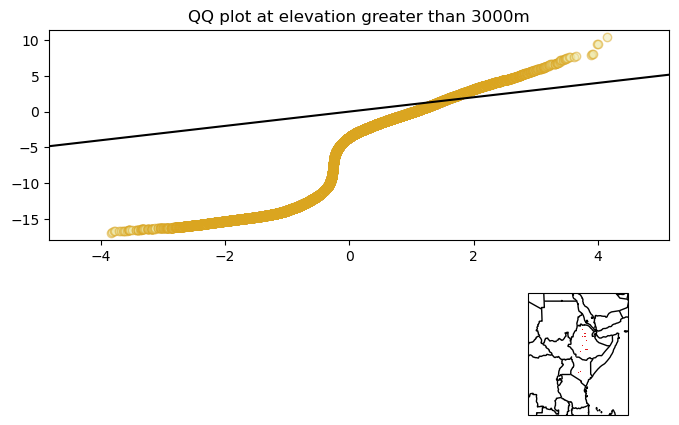

In [380]:
import verification_stats
importlib.reload(verification_stats)

from verification_stats import MAE_xarray, QQ_plot_elev

model = 'graphcast'
times = np.arange('2022-03-01', '2022-06-01', np.timedelta64(1, 'D'), dtype=np.datetime64)
elev = xr.open_dataset('~/cGAN/constants-regICPAC/elev.nc').to_dataarray()

QQ_plot_elev((df_ai.sel({'model':model})*1000/24).rename('preds'), (df_IMERG.precipitation).rename('obs'), elev, level=3000, log=True, times = None)



# Truth vs Pred

2.288845389762631


<Figure size 1200x800 with 0 Axes>

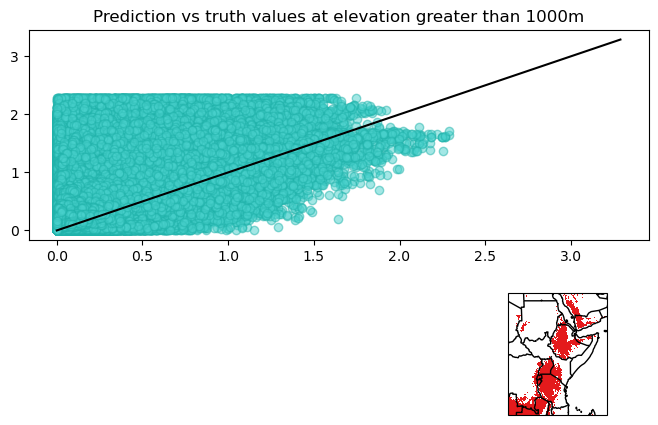

In [193]:
import verification_stats
importlib.reload(verification_stats)

from verification_stats import MAE_xarray, Truth_vs_pred_plot_elev

model = 'fuxi'
times = np.arange('2023-03-01', '2023-05-31', np.timedelta64(1, 'D'), dtype=np.datetime64)
elev = xr.open_dataset('~/cGAN/constants-regICPAC/elev.nc').to_dataarray()

Truth_vs_pred_plot_elev(df_ai.sel({'model':model}).rename('preds')*1000/24, df_IMERG.rename('obs'), elev, level=1000, log=True, times = times)


# Random experimentation with loading in from weatherbench

In [47]:
import pandas as pd

fs = gcsfs.GCSFileSystem(token="anon")

store = fs.get_mapper('gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr')
#gs://gcp-public-data-arco-era5/ar/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr
#gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr

ds = xr.open_zarr(store=store, consolidated=True)#.total_precipitation.sel({\
   # 'latitude':df.latitude.values,
   # 'longitude':df.longitude.values})

#units, reference_date = ds.time.attrs['units'].split('since')
#ds['time'] = pd.date_range(start=referen, periods=ds.sizes['time'], freq='H')


In [12]:
#ds = ds.resample(time='D').mean()
df_era5 = ds.total_precipitation_24hr.sel({'time':np.arange('2018-01-01','2023-01-11',np.timedelta64(1,'D'),dtype='datetime64[ns]')})

In [48]:
ds

<xarray.Dataset> Size: 89TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

In [49]:
df_era5

<xarray.DataArray 'total_precipitation_24hr' (time: 7340, lat: 384, lon: 352)> Size: 4GB
dask.array<astype, shape=(7340, 384, 352), dtype=float32, chunksize=(1, 77, 70), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 59kB 2018-01-01 ... 2023-01-09T18:00:00
  * lat      (lat) float32 2kB -13.65 -13.55 -13.45 -13.35 ... 24.45 24.55 24.65
  * lon      (lon) float32 1kB 19.15 19.25 19.35 19.45 ... 54.05 54.15 54.25
Attributes:
    long_name:      Total precipitation
    short_name:     tp
    units:          m
    regrid_method:  conservative